In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import sklearn
from sklearn.datasets import make_regression as MR
from sklearn.linear_model import LinearRegression as LR, Lasso as LLR
from sklearn.model_selection import train_test_split, KFold, cross_val_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 

import torchvision
from torchvision import *
from torch.nn import *
from NN import NN, ClassificationReport

from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm
 
from sklearn import datasets
from random import shuffle


In [2]:
wine = datasets.load_wine()

In [3]:
X=wine['data']
Y=wine['target']

In [4]:
alphas = [np.e**(x/10) for x in range(-100,-30)]
Scores=[]
for alpha in alphas:
    log_reg = LLR(alpha)
    kfold = KFold(n_splits=10)
    score = cross_val_score(log_reg, X[:100], Y[:100], cv = kfold)
    Scores.append(np.mean(score))
    
alpha=alphas[np.argmax(Scores)]
model=LLR(alpha).fit(X[:100], Y[:100])
Coef=model.coef_

In [5]:
rearange=Coef.argsort()
X=X[:,rearange[::-1]]
font_size=np.array([40, 40, 40, 40, 40, 25, 25, 25, 25, 25, 25, 25, 25])
grid=list(zip([0]*5+[145]*8,list(range(2,252,50))+list(range(2,252,32))))


In [6]:
def sampletoimage(sample):
 img =  Image.fromarray(np.zeros((255,255)).astype('uint8'))
 draw = ImageDraw.Draw(img)    
 for f,s,g in zip(font_size,sample,grid):
  font = ImageFont.truetype("./font.ttf", size=f)
  draw.text(g,str(s),font=font, fill='white')

 return [np.array(img) for _ in range(3)]

In [7]:
X=np.array(list(map(sampletoimage,X)))

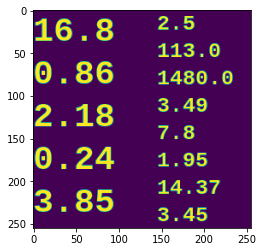

In [8]:
plt.imshow(X[3,0])

### Neural Network

In [9]:
device='cuda:0'
net = NN(model=models.resnet18(pretrained=True),
         cut=1,
         add=Sequential(Linear(512,100),ReLU(),Linear(100,3),Softmax(dim=1)),
         gradients=8)
net=net.to(device)

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=5, shuffle=True)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=3, shuffle=True)
batch_size=64
train_data = torch.utils.data.DataLoader(list(zip(X_train,Y_train)), batch_size=batch_size, shuffle=True, drop_last=True,num_workers=2)
validation_data = torch.utils.data.DataLoader(list(zip(X_val,Y_val)),batch_size=1,num_workers=2) 

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

net.optimization(criterion,optimizer)
Train_stats, Test_stats = net.TRAIN(train_data,validation_data, 
                                    epochs=30, 
                                    batch_size=batch_size,
                                    verbose=1,
                                    random_seed=1,
                                    device=device)


#net.save()

-----      TRAIN RESULTS      -----
{'Epoch': 1.0, 'Accuracy': 0.328125, 'Loss': 1.0976841449737549}
-----      Validation  RESULTS     -----
{'Epoch': 1.0, 'Accuracy': 0.3103448275862069, 'Loss': 1.1097502872861664}
-----      TRAIN RESULTS      -----
{'Epoch': 2.0, 'Accuracy': 0.265625, 'Loss': 1.1092250347137451}
-----      Validation  RESULTS     -----
{'Epoch': 2.0, 'Accuracy': 0.3793103448275862, 'Loss': 1.100040028835165}
-----      TRAIN RESULTS      -----
{'Epoch': 3.0, 'Accuracy': 0.265625, 'Loss': 1.1031886339187622}
-----      Validation  RESULTS     -----
{'Epoch': 3.0, 'Accuracy': 0.2413793103448276, 'Loss': 1.1053782084892536}
-----      TRAIN RESULTS      -----
{'Epoch': 4.0, 'Accuracy': 0.40625, 'Loss': 1.0902785062789917}
-----      Validation  RESULTS     -----
{'Epoch': 4.0, 'Accuracy': 0.2413793103448276, 'Loss': 1.1062997291828025}
-----      TRAIN RESULTS      -----
{'Epoch': 5.0, 'Accuracy': 0.4375, 'Loss': 1.0948996543884277}
-----      Validation  RESULTS     

## Visualization

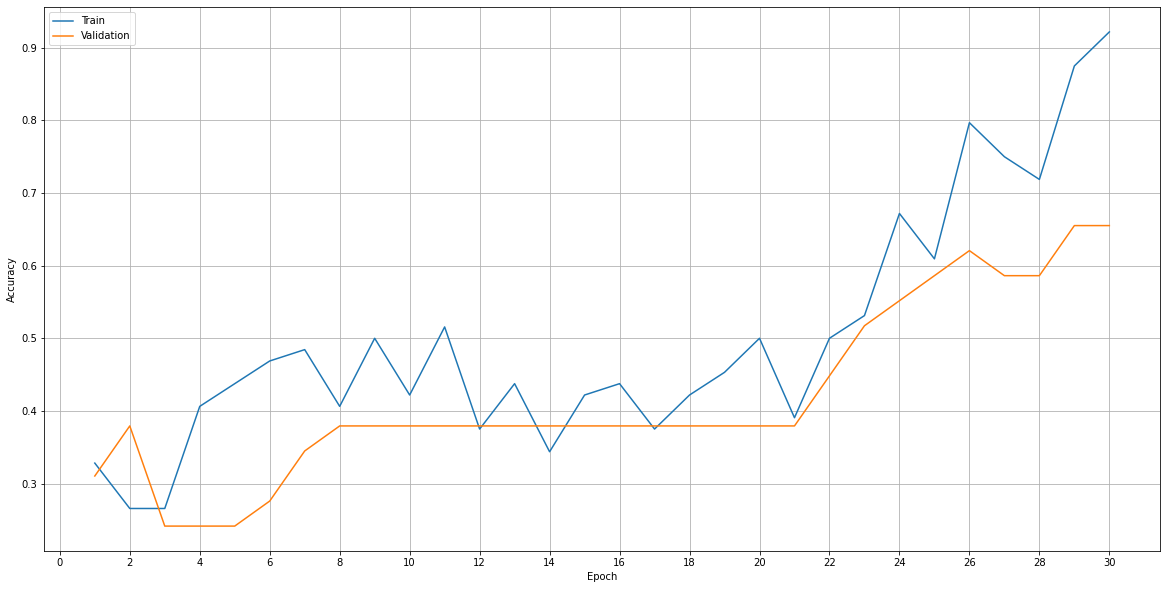

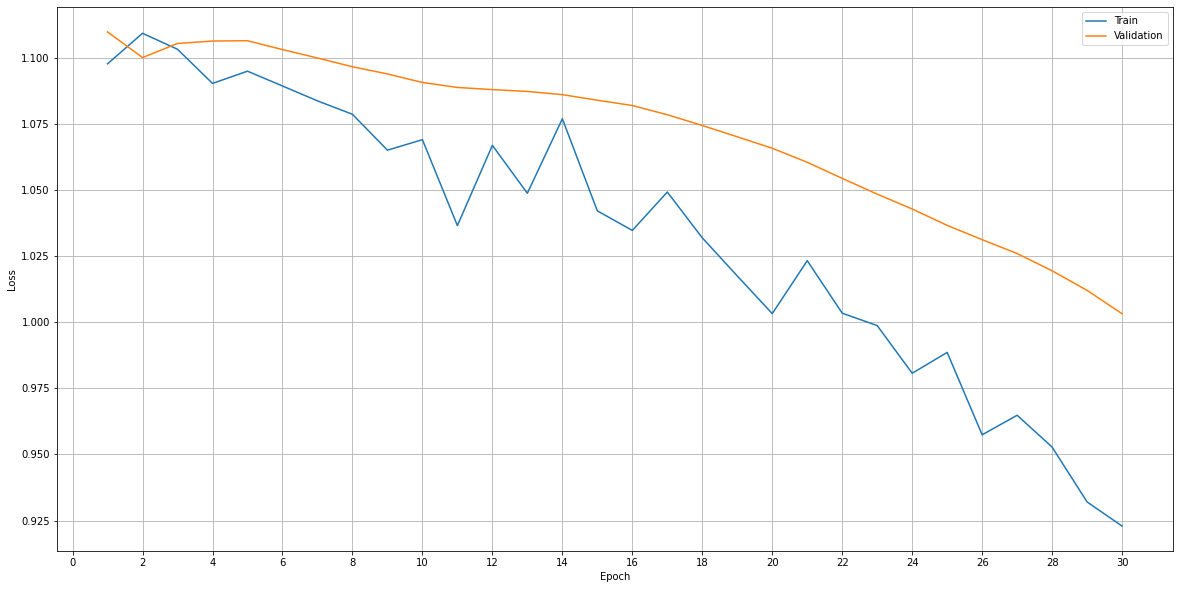

In [11]:
net.plot('Accuracy')
net.plot('Loss')

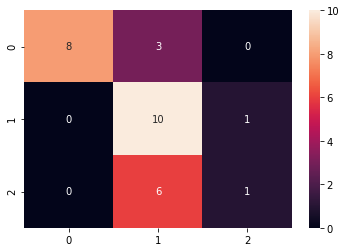

In [12]:
report=ClassificationReport(net)
report.fit(X_val,Y_val)
report.heatmap()

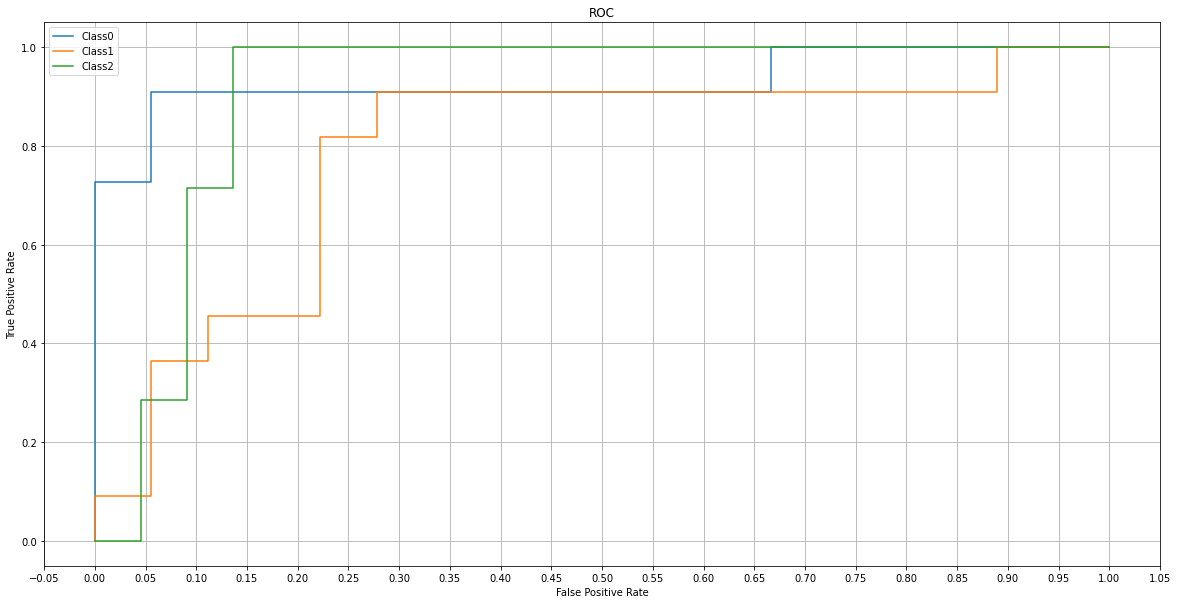

In [13]:
report.plot_ROC()

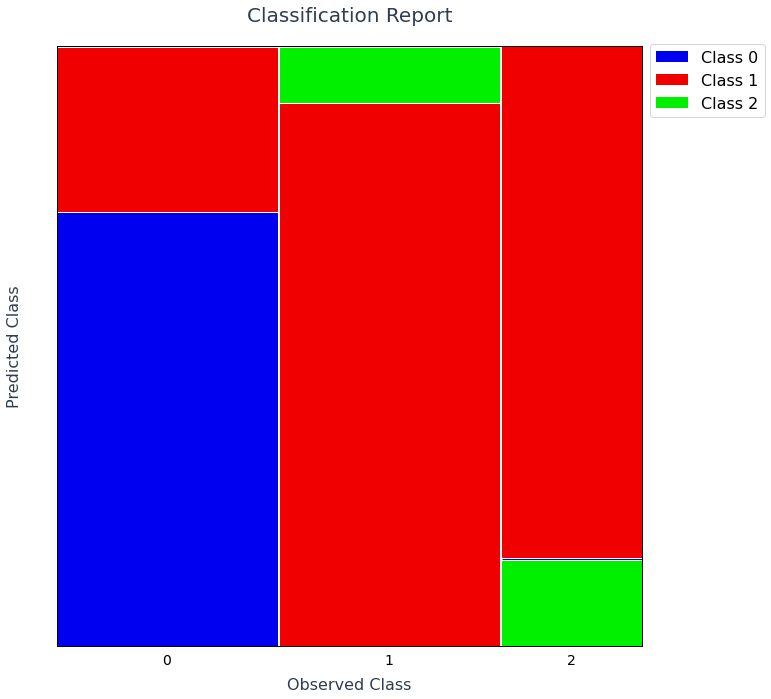

In [14]:
report.mosaic_plot()

In [15]:
report.print_AUC()

Clas_0: 0.9292929292929293
Clas_1: 0.7878787878787878
Clas_2: 0.9090909090909091


In [16]:
print("CROSS ENTROPY:",report.cross_entropy())
print("Accuracy:",report.accuracy())

CROSS ENTROPY: 0.8526706644173326
Accuracy: 0.6551724137931034


### TESTING THE PERFORMANCE

In [17]:
device='cuda:0'
net = NN(model=models.resnet18(pretrained=True),
         cut=1,
         add=Sequential(Linear(512,100),ReLU(),Linear(100,3),Softmax(dim=1)),
         gradients=8)
net=net.to(device)
net.load()

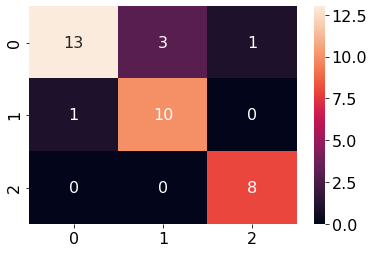

In [18]:
report=ClassificationReport(net)
report.fit(X_test,Y_test)
report.heatmap()

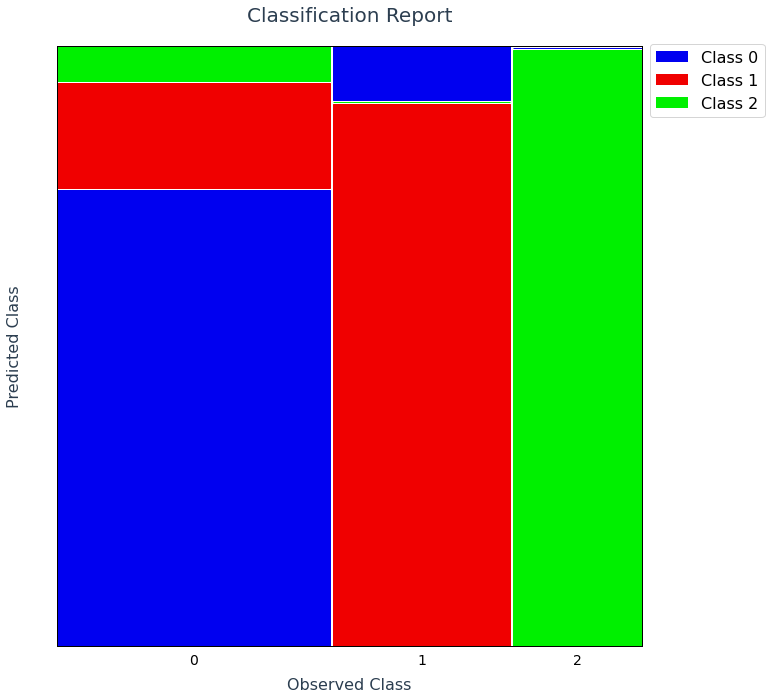

In [19]:
report.mosaic_plot()

In [20]:
report.accuracy()

0.8611111111111112